# Final Project DDPG

Original code wrote by:
Joseph Distefano(jpdistef@buffalo.edu)


In [13]:
# !pip install torch
# !pip install numpy
# !pip install matplotlib
# !pip install gym
# !pip install random 
# !pip install time
# !pip install box2d-py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import random
import time
import math
import sys


import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from collections import deque, namedtuple
from torch.autograd import Variable

# from keras.models import Sequential
# from keras.layers import *
# from keras.optimizers import *

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib import rc, animation
from IPython import display
from IPython.display import HTML
%matplotlib inline



In [11]:
class Critic(nn.Module):
    def __init__(self,state_size,action_size):
        super(Critic,self).__init__()
        self.linear1 = nn.Linear(state_size,64)
        self.linear2 = nn.Linear(action_size+400,300)
        self.critic = nn.Linear(300,1)
        
    def forward(self,state,action):
        out = self.linear1(state)
        out = F.relu(out)
        out = self.linear2(torch.cat([out,a],1))
        out = F.relu(out)
        criticx =self.critic(out)
        return criticx
        
class Actor(nn.Module):
    def __init__(self,state_size,action_size):
        super(Actor,self).__init__()
        self.linear1 = nn.Linear(state_size,400)
        self.linear2 = nn.Linear(400,300)
        self.actor = nn.Linear(300,action_size)
        
    def forward(self,state):
        out = self.linear1(state)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        actorx = F.tanh(self.actor(out)) 
        return actorx


In [16]:
class replay_buffer:
    def __init__(self,mem_size,state_size,action_size,mem_cntr):
        self.mem_size = mem_size
        self.state_memory = np.zeros((self.mem_size, *[state_size]), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *[state_size]), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.uint8)
        self.mem_cntr = mem_cntr
        self.action_size = action_size
        
    def storeTransition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1
        
    def get_sample(self,batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        state_batch = self.state_memory[batch]
        action_batch = self.action_memory[batch]
        reward_batch = self.reward_memory[batch]
        new_state_batch = self.new_state_memory[batch]
        terminal_batch = self.terminal_memory[batch]
        
        return state_batch,action_batch ,reward_batch,new_state_batch,terminal_batch

In [17]:
######### imported this function 
class RandomProcess(object):
    def reset_states(self):
        pass

class AnnealedGaussianProcess(RandomProcess):
    def __init__(self, mu, sigma, sigma_min, n_steps_annealing):
        self.mu = mu
        self.sigma = sigma
        self.n_steps = 0

        if sigma_min is not None:
            self.m = -float(sigma - sigma_min) / float(n_steps_annealing)
            self.c = sigma
            self.sigma_min = sigma_min
        else:
            self.m = 0.
            self.c = sigma
            self.sigma_min = sigma

    @property
    def current_sigma(self):
        sigma = max(self.sigma_min, self.m * float(self.n_steps) + self.c)
        return sigma
    
class OrnsteinUhlenbeckProcess(AnnealedGaussianProcess):
    def __init__(self, theta, mu=0., sigma=1., dt=1e-2, x0=None, size=1, sigma_min=None, n_steps_annealing=1000):
        super(OrnsteinUhlenbeckProcess, self).__init__(mu=mu, sigma=sigma, sigma_min=sigma_min, n_steps_annealing=n_steps_annealing)
        self.theta = theta
        self.mu = mu
        self.dt = dt
        self.x0 = x0
        self.size = size
        self.reset_states()

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.current_sigma * np.sqrt(self.dt) * np.random.normal(size=self.size)
        self.x_prev = x
        self.n_steps += 1
        return x

    def reset_states(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros(self.size)    

In [29]:
class DDPGagent():
    def __init__(self,state_size,action_size,lr,max_mem,tau):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = lr
        self.tau = tau
        
        self.actor = Actor(state_size,action_size) 
        self.actor_target = Actor(state_size,action_size)
        self.critic = Critic(state_size,action_size)
        self.critic_target = Critic(state_size,action_size)
        
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=lr)
        
        self.memory = Replay_Memory(max_mem)
        self.critic_loss = nn.MSELoss()
        self.random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=args.ou_theta, mu=args.ou_mu, sigma=args.ou_sigma)
        
        for target_param, param in zip(self.actor_target.parameters(),self.actor.parameters()):
            target_param.data.copy_(param.data)
        
        for target_param, param in zip(self.critic_target.parameters(),self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        
    def get_action(self,state):
        probs = self.actor(t(state))
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()      
        return action
    
    
    def update(self):
        

In [30]:
env = gym.make("Pendulum-v0")
env.reset()
# plt.imshow(env.render('rgb_array'))

state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]


In [32]:
num_episodes = 50
lr = 0.0005
max_mem = 50000
tau = 0.01
agent = DDPGagent(state_size,action_size,lr,max_mem,tau)
batch_size = 64
gamma = 0.99

episode_rewards = []
step = 0

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action) #.detach().data.numpy())

        agent.memory.add_to_memory(state,action,reward,next_state,done)
        
        if agent.memory.get_memory_size() > batch_size:
                agent.update(batch_size)
                
        total_reward += reward
        state = next_state
        step += 1

#         if done: 
#             break
    
    episode_rewards.append(total_reward)
    print('done')
    if episode % 10 == 0:
        
        print('Episode {}'.format(episode))
        print('Last Episode Reward: {}'.format(total_reward))
        print('-'*10)

TypeError: __init__() missing 3 required positional arguments: 'state_size', 'action_size', and 'mem_cntr'

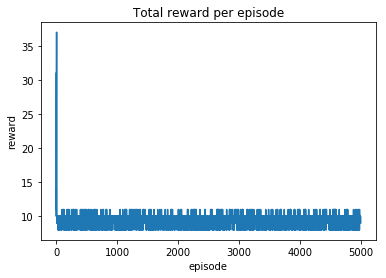

In [215]:
plt.plot(episode_rewards)
plt.title("Total reward per episode")
plt.ylabel("reward")
plt.xlabel("episode")
plt.show()

In [25]:
np.save('DDPG_LunarLander',episode_rewards)

NameError: name 'episode_rewards' is not defined